In [1]:
# General imports
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u

%config InlineBackend.figure_format ='retina'


In [2]:
# TARDIS imports for the gamma-ray code
from tardis.io.atom_data import AtomData
from tardis.model import SimulationState
from tardis.plasma.base import BasePlasma
from tardis.io.configuration import config_reader
from tardis.energy_input.main_gamma_ray_loop import run_gamma_ray_loop
from tardis.plasma.properties import Density, Abundance, IsotopeAbundance, \
    IsotopeNumberDensity, AtomicData, AtomicMass, IsotopeMass, NumberDensity, \
    SelectedAtoms

/Users/anirbandutta/Software/tardis/tardis/__init__.py:20: UserWarning: Astropy is already imported externally. Astropy should be imported after TARDIS.
  warnings.warn(


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [3]:
# Download the atom data file from tardis-regression-data repo to run this cell.
atom_data_file = 'kurucz_cd23_chianti_H_He.h5'
atom_data = AtomData.from_hdf(atom_data_file)

INFO:tardis.io.atom_data.util:
	Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path.
	Exists in TARDIS Data repo /Users/anirbandutta/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5
INFO:tardis.io.atom_data.base:Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace 
INFO:tardis.io.atom_data.base:Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data, linelist


In [4]:
# Read the config file and create a configuration object

config_file = Path("../../io/configuration/tests/data/tardis_configv1_density_exponential_nebular_Ni_only.yml")
config = config_reader.Configuration.from_yaml(config_file)

In [5]:
# Create the model
model = SimulationState.from_config(config, atom_data)


INFO:tardis.model.matter.decay:Decaying abundances for 12960000.0 seconds
/Users/anirbandutta/Software/tardis/tardis/model/matter/composition.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.288214564694115e-23' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  isotope_mass_df[isotope_tuple] = isotope_mass


In [6]:
# This shows the isotope abundances in the model before decay
model.composition.raw_isotope_abundance

,,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
atomic_number,mass_number,,,,,,,,,,,,,,,,,,,,
28,56,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167


In [7]:
# Construct the Plasma

input = [Density, Abundance, IsotopeAbundance, AtomicData, AtomicMass, IsotopeNumberDensity, NumberDensity, SelectedAtoms, IsotopeMass]

plasma = BasePlasma(plasma_properties=input, density = model.density, 
                    abundance=model.abundance, isotope_abundance=model.composition.raw_isotope_abundance,
                    atomic_data = atom_data)

In [8]:
# Define the number of MC packets
num_packets =  2000000

np.random.seed(1)

In [9]:
# Execute this cell to run the simulation
energy_df, energy_plot_df, escape_energy, decayed_packet_count, energy_plot_positrons, \
       energy_estimated_deposition =  run_gamma_ray_loop(model, plasma, num_decays=num_packets, 
                                         time_start=0.0011574074, time_end=20.0, time_space="log", 
                                         time_steps=50, seed=1, positronium_fraction=0.0,
                                         spectrum_bins=1000, grey_opacity=-1, 
                                         atom_data=atom_data)

INFO:tardis.energy_input.main_gamma_ray_loop:Total gamma-ray energy is 6.51100757656281e+45
INFO:tardis.energy_input.main_gamma_ray_loop:Total number of packets is 1999983
INFO:tardis.energy_input.main_gamma_ray_loop:Energy per packet is 3.255531460298818e+39
INFO:tardis.energy_input.main_gamma_ray_loop:Initializing packets
/Users/anirbandutta/Software/tardis/tardis/energy_input/util.py:72: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  return 1 - (np.dot(direction_vector, velocity_vector) / C_CGS)
INFO:tardis.energy_input.main_gamma_ray_loop:Creating packet list
INFO:tardis.energy_input.main_gamma_ray_loop:Total cmf energy is 6.510584035699688e+45
INFO:tardis.energy_input.main_gamma_ray_loop:Total rf energy is 6.515740996756502e+45
/Users/anirbandutta/Software/tardis/tardis/energy_input/gamma_packet_loop.py:201: NumbaPerformanceWarning: np.dot() is faster on contig

Entering gamma ray loop for 1999983 packets
Escaped packets: 531945
Scattered packets: 154689


[]

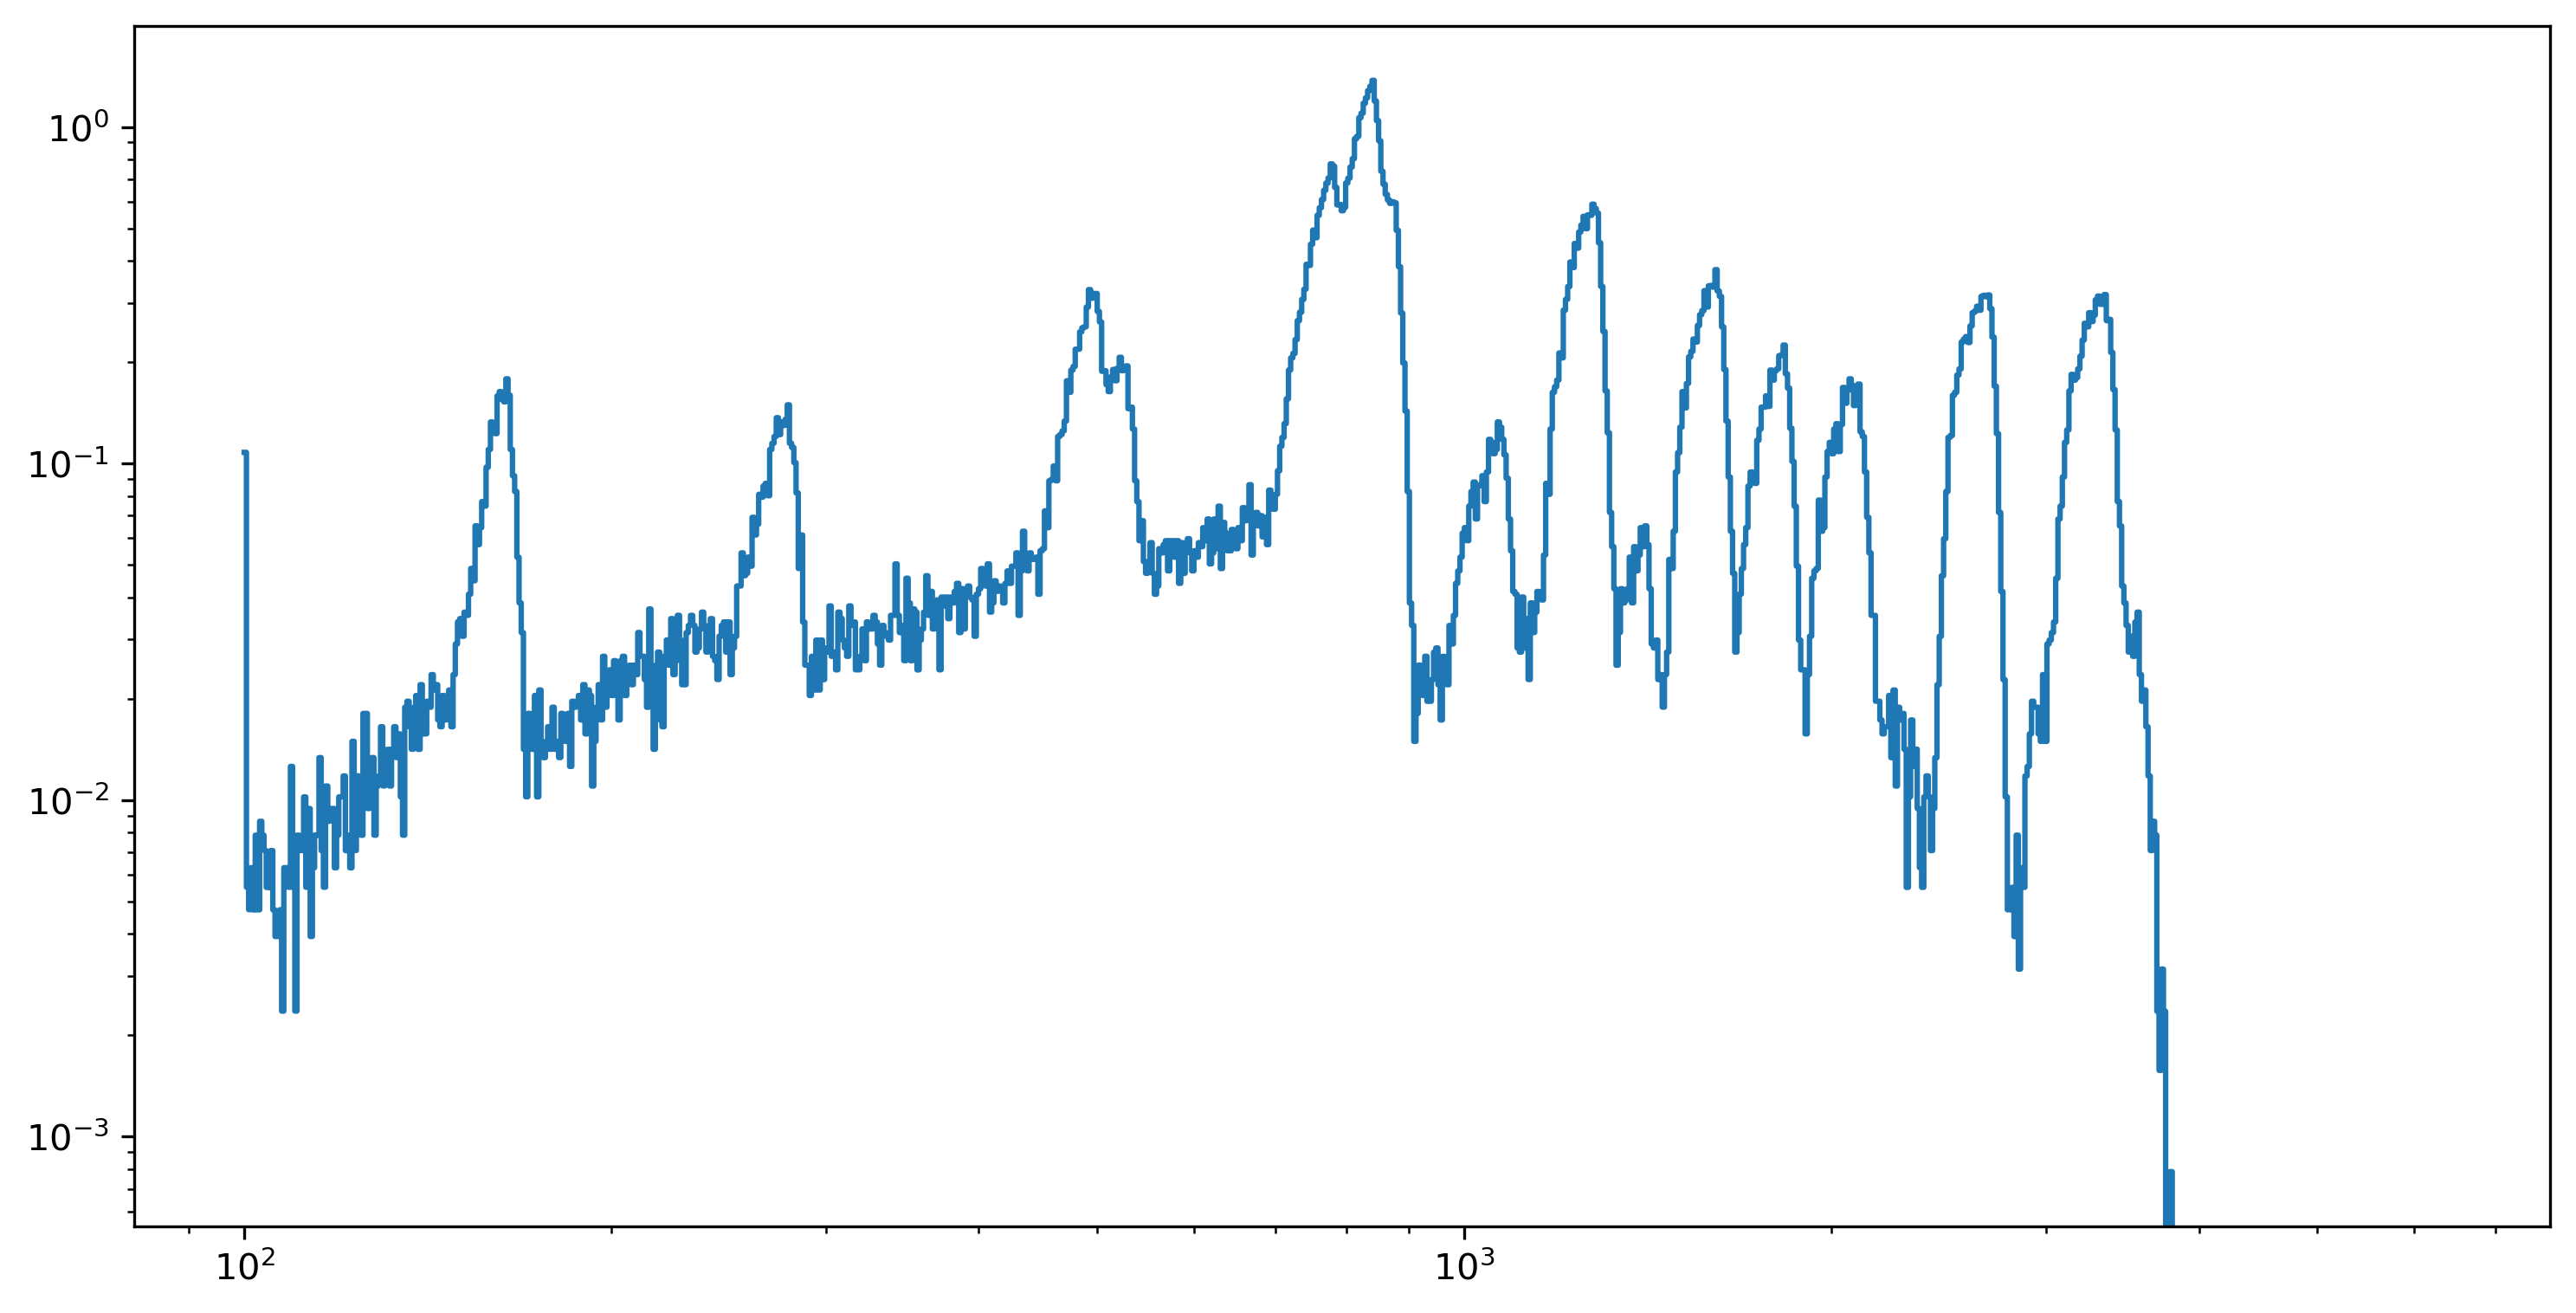

In [10]:
plt.figure(figsize=(12, 6), dpi=150)
plt.step(escape_energy.index, escape_energy.iloc[:,49], label="$\gamma$-spectrum", where="post")
plt.loglog()
